## Import the necessary libraries

In [ ]:
import sys

from scipy.optimize import curve_fit

sys.path.append("../../src")

from relaxometrynmr.core import T1Functions

import numpy as np

import matplotlib.pyplot as plt

## specify path to the data file and ensure that "\\\\" is appended to the end of the path

 - create an instance t1 of T1Functions

In [2]:
filepath = r"..\..\data\T1_data\1\\"

t1 = T1Functions(filepath)

## Read and convert Bruker NMR data to NMRPipe and CSDM formats: read_and_convert_bruker_data.

The function automatically detects and loads the variable delay list (vdlist, vplist, vclist) used in the experiment.

It returns a tuple containing three elements: a list of 1D NMR (spectra), the variable delay list (vd_list), and the complete dataset in CSDM format (csdm_ds)

In [3]:
spectra, vd_list, csdm_ds = t1.read_and_convert_bruker_data(filepath)

## Process the returned 1D NMR spectra
 - apply the Gaussian apodisation (fwhm)
 - zero-filling for increased digital resolution (zero_fill_factor)
 - 0th order phase correction (ph0)
 - 1st order phase correction (ph1) -- this phase correction is a bit nuanced and so far, a value of 0 - 0.6 ° has worked quite well: see the "Understanding Phasing" example under User Guide
 - In applying the 1st order correction, you would have to experiment with the mentioned values to obtain a pure absorption line-shape signal

In [4]:
exp_spectra = []
for i, spectrum in enumerate(spectra):
    if i == 1 :
        exp_spectrum = t1.process_spectrum(spectrum, fwhm="500 Hz", zero_fill_factor=10, ph0=70, ph1=0.55)
        exp_spectra.append(exp_spectrum)
    elif i == 2:
        exp_spectrum = t1.process_spectrum(spectrum, fwhm="500 Hz", zero_fill_factor=10, ph0=100, ph1=0.55)
        exp_spectra.append(exp_spectrum)
        
    elif i == 5:
        exp_spectrum = t1.process_spectrum(spectrum, fwhm="500 Hz", zero_fill_factor=10, ph0=70, ph1=0.52)
        exp_spectra.append(exp_spectrum)
    elif i == 6:
        exp_spectrum = t1.process_spectrum(spectrum, fwhm="500 Hz", zero_fill_factor=10, ph0=30, ph1=0.5)
        exp_spectra.append(exp_spectrum)
    else:
        exp_spectrum = t1.process_spectrum(spectrum, fwhm="500 Hz", zero_fill_factor=10, ph0=50, ph1=0.5)
        exp_spectra.append(exp_spectrum)

## Find the area under the peak of interest using the ``integrate_spectrum_region()`` function
The integration function employed here integrate each spectrum using trapezoid and simpson function, respectively.
ppm_start and ppm_end need to be defined as the starting and ending ppm region needed to be integrated. 
The integrated area of each spectrum is appended to trapz_ints and simps_ints, respectively.
x_ and y_regions are regions of integration in the spectra -- needed for visuals.


 - There is no difference between trapz and simps, so you would have to use either of the two in a later stage

In [5]:
trapz_ints = []
simps_ints = []
x_regions = []
y_regions = []
int_uncs = []

for i, exp_spectrum in enumerate(exp_spectra):
    trapz_int, simps_int, x_region, y_region, int_unc = t1.integrate_spectrum_region(exp_spectrum, ppm_start=500, ppm_end=650)
    trapz_ints.append(trapz_int)
    simps_ints.append(simps_int)
    x_regions.append(x_region)
    y_regions.append(y_region)
    int_uncs.append(int_unc)

## plot_spectra_and_zoom() function
 - creates plots of NMR spectra with both full view and zoomed regions (max and min x zoom)
 - highlights the integrated x_ and y_regions on the zoomed plot
 - returns maximum intensities from each spectrum (abs_ints): relevant for relaxometry just like integrated areas contained in trapz_ints and simps_ints

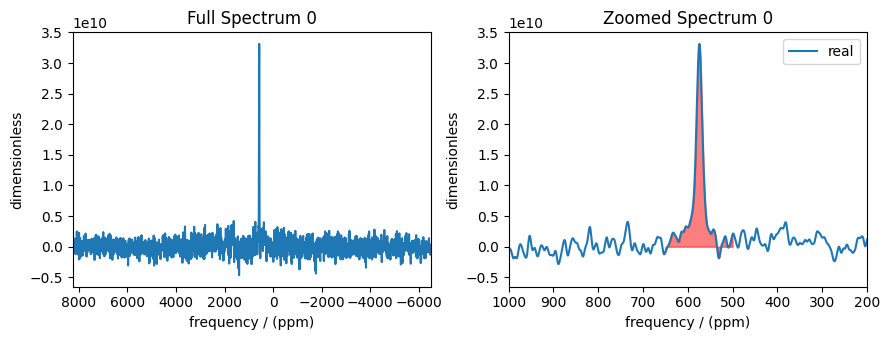

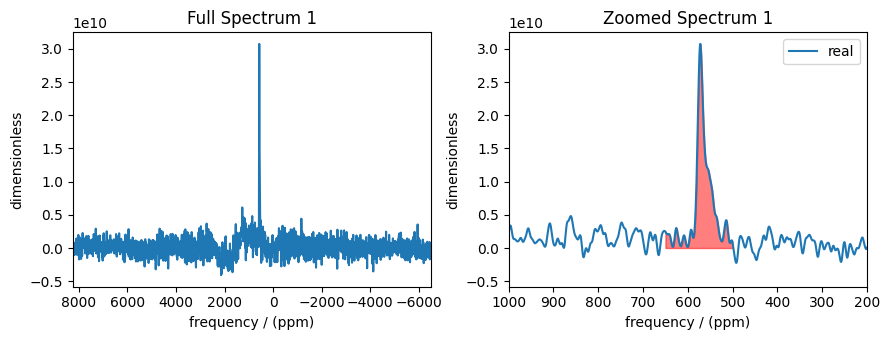

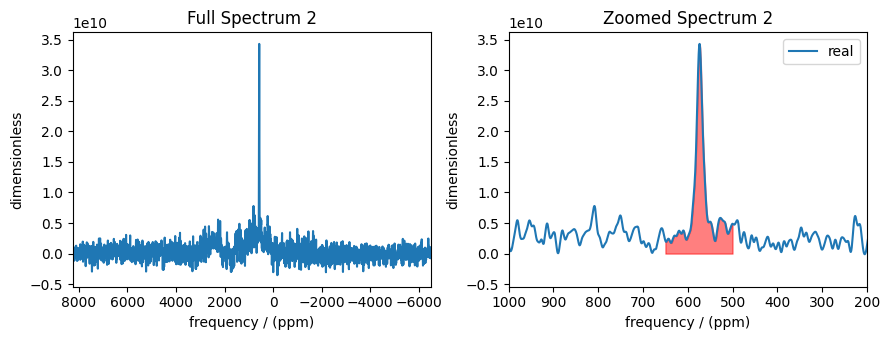

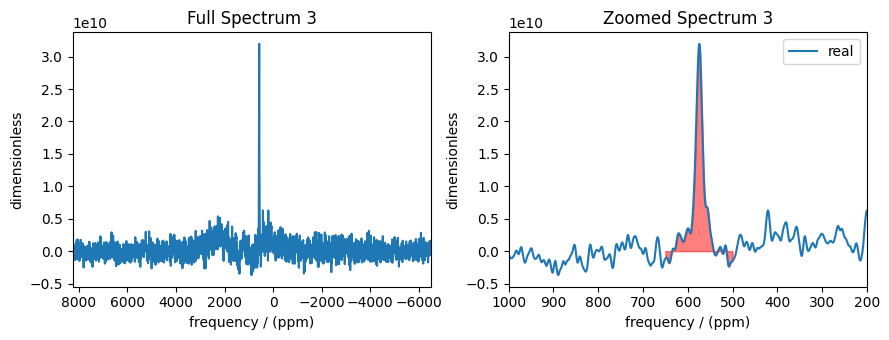

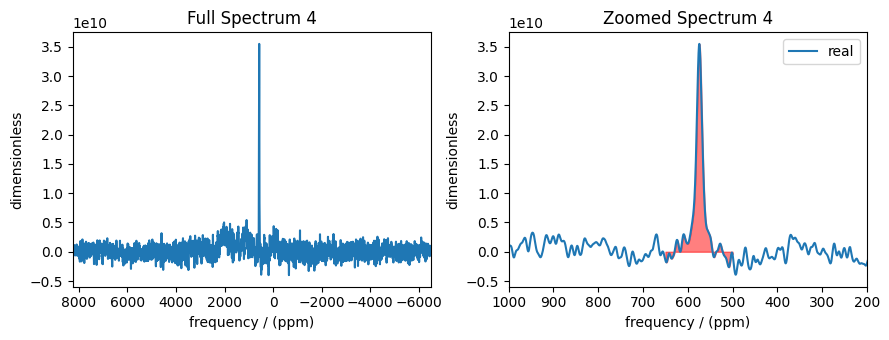

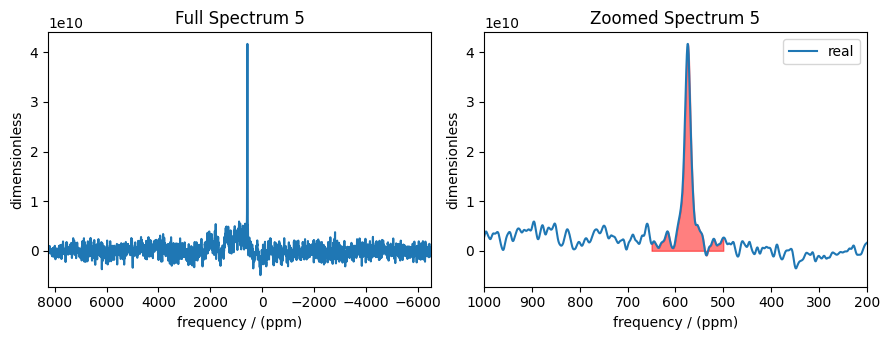

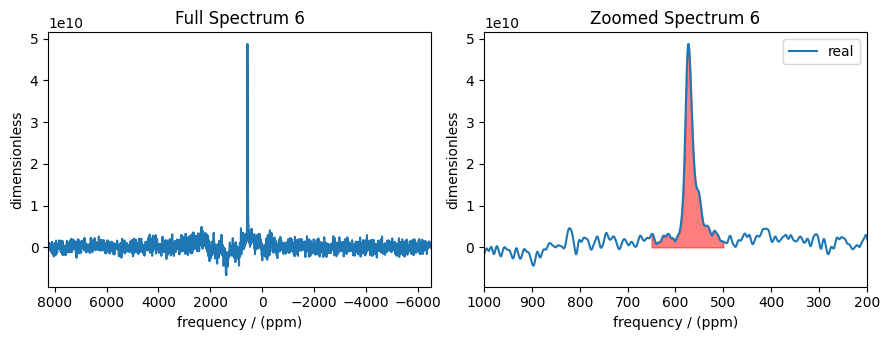

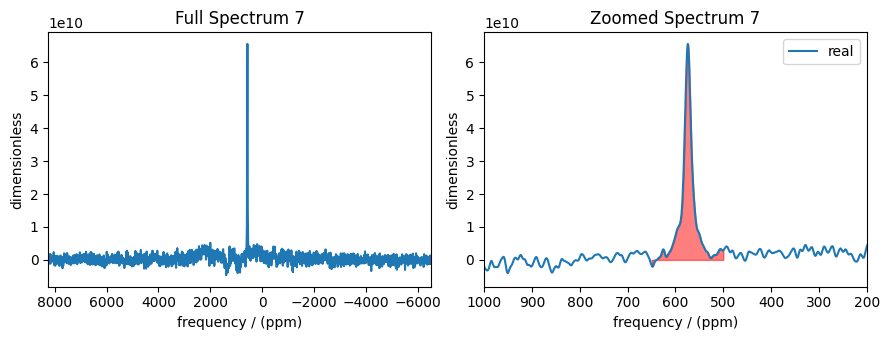

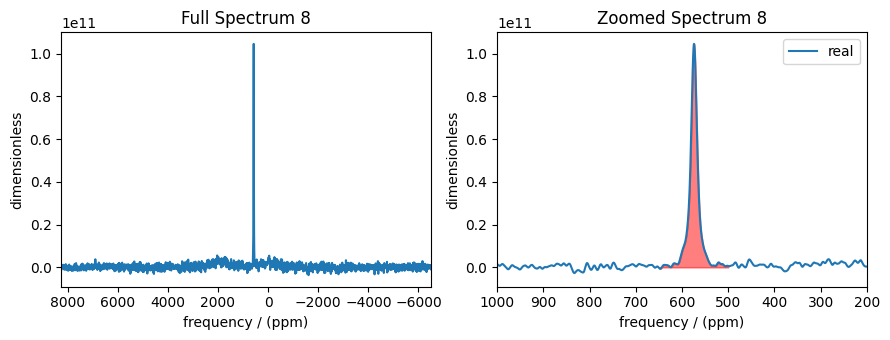

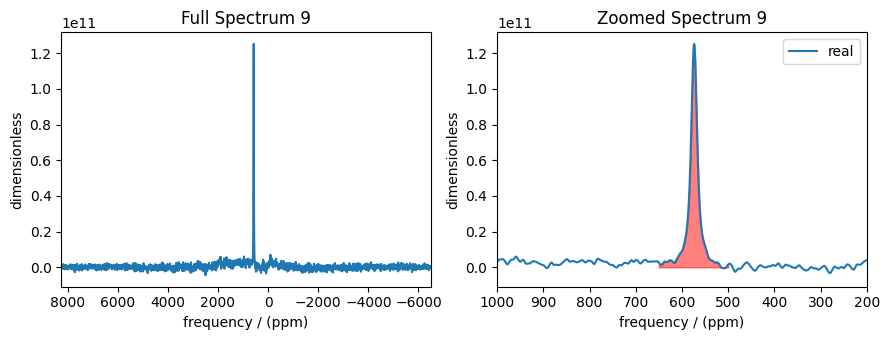

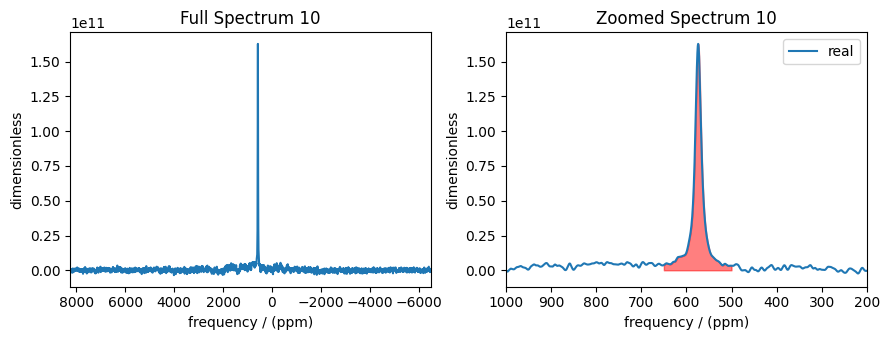

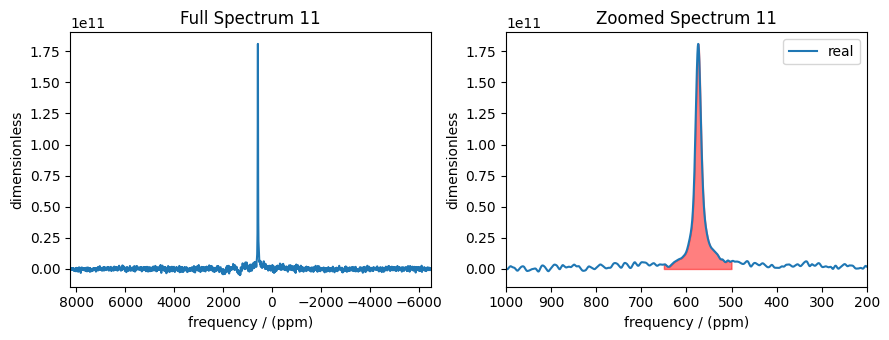

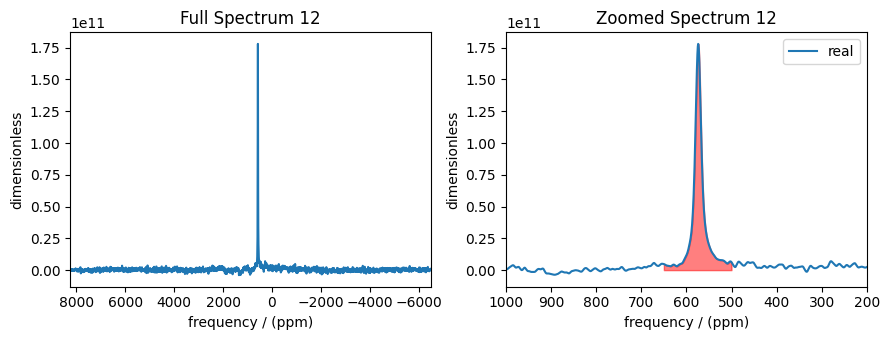

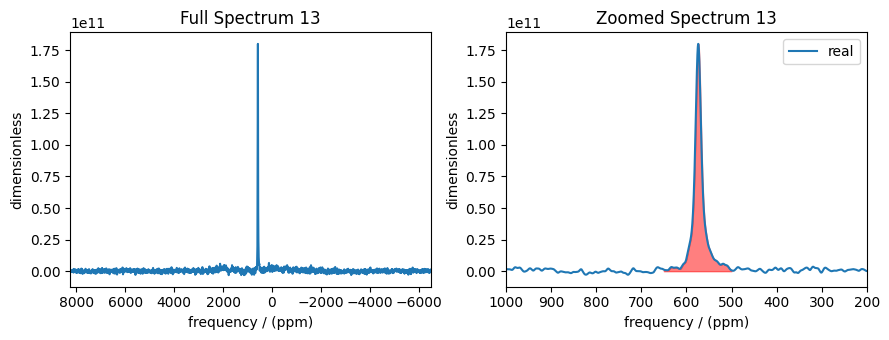

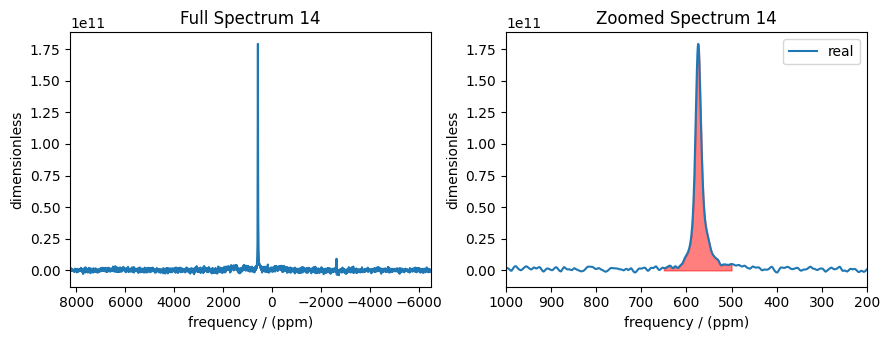

In [6]:
max_x_zoom = 1000

min_x_zoom = 200

abs_ints = t1.plot_spectra_and_zoomed_regions(exp_spectra, x_regions, y_regions, max_x_zoom, min_x_zoom)

## Convert vd list to numpy array and ensure that the list and extracted intensities and areas are of the same length 

In [7]:
# vd_list imported from the file_path is converted into a numpy array

vd_list = np.array(vd_list)

# slicing the vd_list if some data points are missing

vd_list = vd_list[:len(abs_ints)]


simps_ints = simps_ints[:len(vd_list)]

abs_ints = abs_ints[:len(vd_list)]

## Viusalise the list and the extracted intensities and areas
 - the extracted areas from either trapz or simps integration and extracted max intensities of each spectrum are plotted against corresponding time in vd_list

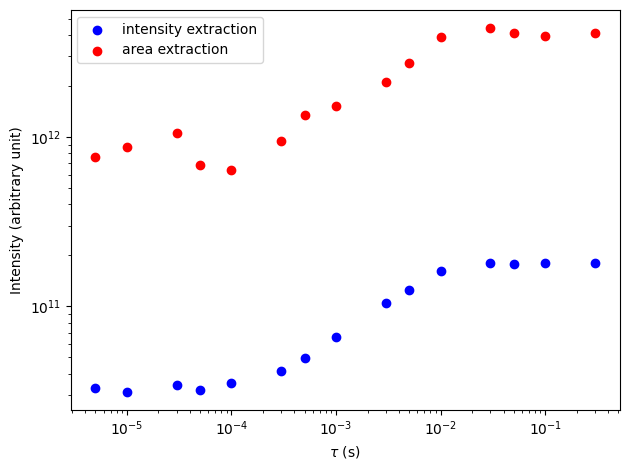

In [8]:
fig, ax = plt.subplots()

ax.scatter(vd_list, abs_ints, color='blue', label='intensity extraction')


ax.scatter(vd_list, simps_ints, color='red', label='area extraction')


ax.semilogy()

ax.semilogx()

ax.legend(loc='best', frameon=True)

ax.set_xlabel(r'$\tau$ (s)')
ax.set_ylabel('Intensity (arbitrary unit)')



plt.tight_layout()

plt.show()

## Let us fit one of the data with a simple exponential satrec function: here we are using the intensities, the areas can also be utilised

M0_intensities: 0.8295563618067949 ± 60049561288401.65
T1_intensities: 0.004644172807209871 ± 0.00020369617126654092
A_intensities: 176827806117.40628 ± 1.2800133504869488e+25
B_intensities: 32856412289.666718 ± 933502453.4584883


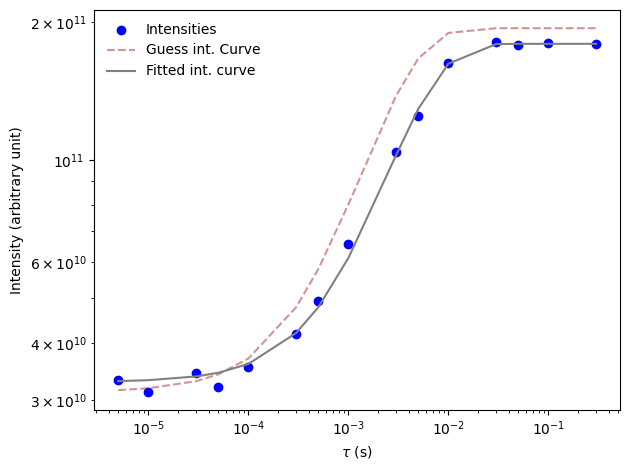

In [9]:

fig, ax = plt.subplots()

output_lines = []

# Define a list of tuples for the two sets of intensities
intensity_sets = [
    (simps_ints, 'Simps Area', 'Guess Curve', 'Fitted Curve', 'r'),
    (abs_ints, 'Intensities', 'Guess int. Curve', 'Fitted int. curve', 'b')
]


# Initial guess parameters
M0_guess = 0.9
T1_guess = 2.8e-3

for i, (ints, label, guess_label, fitted_label, color) in enumerate(intensity_sets):
    # here we are using the maximum intensity of each spectrum to 
    # extract the spin-lattice relaxation time, you can use the integrated area of each spectum as well by setting i == 0
    if i == 1:
        A_guess = np.max(ints)
        B_guess = np.min(ints)
    
        # Scatter plot
        ax.scatter(vd_list, ints, color=color, label=label)
    
        # Guess curve
        guess_integrated_int = t1.mono_satrec_func(vd_list, M0_guess, T1_guess, A_guess, B_guess)
        ax.plot(vd_list, guess_integrated_int, color='brown', linestyle='--', label=guess_label, alpha=0.5)
    
        # Fit the data
        popt, pcov = curve_fit(t1.mono_satrec_func, vd_list, ints, p0=[M0_guess, T1_guess, A_guess, B_guess])
    
        # Save the fitted params and uncertainties
        M0_fitted, T1_fitted, A_fitted, B_fitted = popt
        M0_unc, T1_unc, A_unc, B_unc = np.sqrt(np.diag(pcov))
    
        # Extract the fitted curve
        fitted_curve = t1.mono_satrec_func(vd_list, M0_fitted, T1_fitted, A_fitted, B_fitted)
        ax.plot(vd_list, fitted_curve, linestyle='-', color='grey', label=fitted_label)
    
        # Print the fitted parameters and uncertainties
        print(f'M0_{label.lower().replace(" ", "_")}: {M0_fitted} ± {M0_unc}')
        print(f'T1_{label.lower().replace(" ", "_")}: {T1_fitted} ± {T1_unc}')
        print(f'A_{label.lower().replace(" ", "_")}: {A_fitted} ± {A_unc}')
        print(f'B_{label.lower().replace(" ", "_")}: {B_fitted} ± {B_unc}')
    
        #Format the string and append fitted parameters
    
        output_lines.append(f'M0_{label.lower().replace(" ", "_")}: {M0_fitted} ± {M0_unc}\n')
        output_lines.append(f'T1_{label.lower().replace(" ", "_")}: {T1_fitted} ± {T1_unc}\n')
        output_lines.append(f'A_{label.lower().replace(" ", "_")}: {A_fitted} ± {A_unc}\n')
        output_lines.append(f'B_{label.lower().replace(" ", "_")}: {B_fitted} ± {B_unc}\n')
        #save the fitted params and uncertainties in a text file
        with open(filepath+'mono_exp_fitted_params.txt', 'w') as f:
            f.writelines(output_lines)

ax.semilogy()
ax.semilogx()
ax.legend(loc='best', frameon=False)
ax.set_xlabel(r'$\tau$ (s)')
ax.set_ylabel('Intensity (arbitrary unit)')
plt.tight_layout()
plt.savefig(filepath+'mono_exp_T1_fitting.svg', bbox_inches='tight', transparent=True)
plt.show()
plt.clf()
plt.close()

## Understanding the optimised parameters
  - M0_intensities == equilibrium magnetisation
  - T1_intensities == spin-lattice relaxation time in seconds
  - B_intensities == Baseline offset
  - A_intensities == scaling factor for the overall amplitude